# Yu-Gi-Oh! Trading Card Game Analysis

![alt text](C:/Users/Robin/Documents/nosql_project/ygo_logo.jpg "Title")

<h1>Table of Contents</h1>
<div class="toc">
  <ul>
    <li>
      <a href="#1-Summary">1 Summary</a>
    </li>
    <li>
      <a href="#2-Requirements-&amp;-Configuration">2 Requirements &amp; Configuration</a>
    </li>
    <li>
      <a href="#3-ELT-Process">3 ELT Process</a>
      <ul>
        <li>
          <a href="#3.1-DB-Setup">3.1 DB Setup</a>
        </li>
        <li>
          <a href="#3.2-Extract">3.2 Extract</a>
        </li>
          <ul>
            <li>
              <a href="#3.2.1-Fetching-all-the-card-images">3.2.1 Fetching all the card images</a>
            </li>
          </ul>
        <li>
          <a href="#3.3-Load">3.3 Load</a>
        </li>
        <li>
          <a href="#3.4-Transform">3.4 Transform</a>
          <ul>
            <li>
              <a href="#3.4.1-Fixing-Data-Types">3.4.1 Fixing Data Types</a>
            </li>
            <li>
              <a href="#3.4.2-Check-for-duplicates">3.4.2 Check for duplicates</a>
            </li>
          </ul>
        </li>
        <li>
          <a href="#3.5-Data-Structure">3.5 Data Structure</a>
        </li>
      </ul>
    </li>
    <li>
      <a href="#4-Data-Analysis">4 Data Analysis</a>
      <ul>
        <li>
          <a href="#4.1-Which-card-has-the-most-re-printings?">4.1 Which card has the most re-printings?</a>
        </li>
        <li>
          <a href="#4.2-Most-expensive-cards-based-on-set-prices">4.2 Most expensive cards based on set prices</a>
        </li>
        <li>
          <a href="#4.3-Sets-containing-the-most-expensive-cards">4.3 Sets containing the most expensive cards</a>
        </li>
        <li>
          <a href="#4.4-Card-Rarities-per-Set-Over-the-Years">4.4 Card Rarities per Set Over the Years</a>
        </li>
        <li>
          <a href="#4.5-Count-Cards-by-Type">4.5 Count Cards by Type</a>
        </li>
        <li>
          <a href="#4.6-Card-Popularity">4.6 Card Popularity</a>
        </li>
        </ul>
    </li>
        <li>
            <a href="#5-Conclusions">5 Conclusions</a>
        </li>
        <li>
            <a href="#6-Learnings">6 Learnings</a>
        </li>
</div>

<div style="page-break-after: always;"></div>

# 1 Summary

The Yu-Gi-Oh! Trading Card Game (TCG) is a strategic and captivating duel card game that has fascinated players worldwide since its release in Japan in 1999. The game is based on Duel Monsters, a fictional game created by manga artist Kazuki Takahashi. In Yu-Gi-Oh! TCG, two players face off in a match with the objective of reducing their opponent's life points to zero. This is achieved by using a carefully assembled deck of cards. 
The game includes various cards, such as Monsters, Spells, and Traps. Each card has unique abilities and strategies for use in battle. To win, players must skillfully build their decks, anticipate their opponent's moves, and execute their strategies with precision. Yu-Gi-Oh! TCG has compelling gameplay and a rich lore, drawing from the narratives of the manga and anime series. 

# 2 Requirements & Configuration

In [1]:
import pymongo
import pprint as pp
import pandas as pd
import requests
import time
from IPython.display import display, Image
from PIL import Image as PILImage
import io
import base64
from datetime import datetime
import matplotlib.pyplot as plt

In [29]:
# possible pandas option to set here
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 50)

In [3]:
API_URL = "https://db.ygoprodeck.com/api/v7/cardinfo.php?misc=yes"
CNX_STR = "mongodb://localhost:27017"

<div style="page-break-after: always;"></div>

# 3 ELT-Process

The ELT process consists of three main steps: Extract, Load, and Transform. In the Extract step, we will fetch the card data from multiple Yu-Gi-Oh! API endpoints and download the card images. In the Load step, we will insert the data into the MongoDB database that is locally hosted and run in a Docker container due to the large space required by the images. In the Transform step, we will clean and structure the data to prepare it for analysis.

<img src="C:/Users/Robin/Documents/nosql_project/images/process_diagram.png" alt="alt text" width="1000" height="300"/>

## 3.1 DB Setup

In [4]:
# connect to the database
client = pymongo.MongoClient(CNX_STR)

# specify db and collections
db = client["ygo_cards"]
cards = db["card_info"]
images = db['card_images']
card_sets = db['card_sets']

# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [5]:
db.list_collection_names()

['card_info', 'card_images', 'rarities_per_set', 'card_sets']

<div style="page-break-after: always;"></div>

## 3.2 Extract

We will first fetch the card data from the API and have a look at it. The API provides information about each card, including its name, type, attribute, level, ATK/DEF points, card text and more.

In [9]:
# downloading all the cards from the API
r = requests.get(API_URL)
data = r.json()

In [10]:
# having a look at the first card
pp.pprint(data['data'][1])

{'archetype': 'Alien',
 'card_images': [{'id': 64163367,
                  'image_url': 'https://images.ygoprodeck.com/images/cards/64163367.jpg',
                  'image_url_cropped': 'https://images.ygoprodeck.com/images/cards_cropped/64163367.jpg',
                  'image_url_small': 'https://images.ygoprodeck.com/images/cards_small/64163367.jpg'}],
 'card_prices': [{'amazon_price': '0.50',
                  'cardmarket_price': '0.12',
                  'coolstuffinc_price': '0.25',
                  'ebay_price': '1.25',
                  'tcgplayer_price': '0.20'}],
 'card_sets': [{'set_code': 'GLAS-EN062',
                'set_name': "Gladiator's Assault",
                'set_price': '0',
                'set_rarity': 'Common',
                'set_rarity_code': '(C)'}],
 'desc': 'Each time an A-Counter(s) is removed from play by a card effect, '
         'place 1 A-Counter on this card. When this card is destroyed, '
         'distribute the A-Counters on this card among face

### 3.2.1 Fetching all the card images

The API provides a URL to the image of each card, we can download the images and store them in the database as base64 encoded strings.
A card can have multiple images, in the case of multiple images we will only store the first image, since the images take up a considerable amount of space.

In [ ]:
# loop through all the cards and download the images
for card in data['data']:
    card_name = card['name']
    image_url = card['card_images'][0]['image_url']
    image_response = requests.get(image_url)
    
    # Encode the image to base64
    image_b64 = base64.b64encode(image_response.content)
    
    # Save the encoded image to MongoDB
    images.insert_one({
        'name': card_name,
        'image': image_b64
    })
    time.sleep(0.1) # delay to not exceed the rate limit

In [ ]:
def display_resized_image(image_name=None, new_size=(300, 450)):
    if image_name is None:
        r = images.find_one()
    else:
        # Retrieve the image from the database
        r = images.find_one({"name": image_name})

    # Decode the base64-encoded image
    image_data = base64.b64decode(r['image'])

    # Convert the binary data to a PIL Image object
    image_new = PILImage.open(io.BytesIO(image_data))

    # Resize the image
    resized_image = image_new.resize(new_size)

    # Display the resized image
    display(resized_image)
 

<div style="page-break-after: always;"></div>

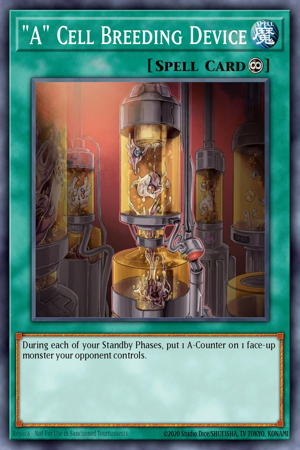

In [24]:
# Display a resized image
display_resized_image()

<div style="page-break-after: always;"></div>

## 3.3 Load

In [ ]:
%%capture
# we can easily insert the list containing all the data into the database
cards.insert_many(data['data'])

In [5]:
# check if the data is in the database
cards.count_documents({})

13030

In [8]:
# show random card
pp.pprint(cards.find_one())

{'_id': ObjectId('660592ebef8a28605d753112'),
 'archetype': 'Alien',
 'card_images': [{'id': 34541863,
                  'image_url': 'https://images.ygoprodeck.com/images/cards/34541863.jpg',
                  'image_url_cropped': 'https://images.ygoprodeck.com/images/cards_cropped/34541863.jpg',
                  'image_url_small': 'https://images.ygoprodeck.com/images/cards_small/34541863.jpg'}],
 'card_prices': [{'amazon_price': 24.45,
                  'cardmarket_price': 0.07,
                  'coolstuffinc_price': 0.25,
                  'ebay_price': 0.99,
                  'tcgplayer_price': 0.17}],
 'card_sets': [{'set_code': 'FOTB-EN043',
                'set_name': 'Force of the Breaker',
                'set_price': 0.0,
                'set_rarity': 'Common',
                'set_rarity_code': '(C)'}],
 'desc': 'During each of your Standby Phases, put 1 A-Counter on 1 face-up '
         'monster your opponent controls.',
 'frameType': 'spell',
 'id': 34541863,
 'misc_inf

### 3.3.1 Additional Set Information

Using the cardsets endpoint from the API we can get additional valuable information about the sets the cards were released in, such as the release date and the number of cards in the set.

In [10]:
# get dates for the sets
r = requests.get("https://db.ygoprodeck.com/api/v7/cardsets.php")
data = r.json()

data[0]

{'set_name': '2-Player Starter Deck: Yuya & Declan',
 'set_code': 'YS15',
 'num_of_cards': 42,
 'tcg_date': '2015-05-28',
 'set_image': 'https://images.ygoprodeck.com/images/sets/YS15.jpg'}

In [ ]:
%%capture
# insert additional set information into the database
card_sets.insert_many(data)

In [11]:
card_sets.find_one()

{'_id': ObjectId('66069f9eef8a28605d7596df'),
 'set_name': '2-Player Starter Deck: Yuya & Declan',
 'set_code': 'YS15',
 'num_of_cards': 42,
 'tcg_date': datetime.datetime(2015, 5, 28, 0, 0),
 'set_image': 'https://images.ygoprodeck.com/images/sets/YS15.jpg'}

<div style="page-break-after: always;"></div>

## 3.4 Transform

### 3.4.1 Fixing Data Types

Converting the date in the card_sets collection to a proper date object results in an error, this is due to the fact that some of the dates are not in the correct format, being shown as 0000-00-00. We have to handle the date conversion differently and will treat this case with a missing value

In [ ]:
%%capture
card_sets.update_many(
    {}, 
    [
        {"$set": {
            "tcg_date": {
                "$cond": {
                    "if": {"$ne": ["$tcg_date", "0000-00-00"]},  # Check if tcg_date is not '0000-00-00'
                    "then": {"$toDate": "$tcg_date"},  # If true, convert tcg_date to date
                    "else": None  # If false, set tcg_date to None or choose another placeholder
                }
            }
        }}
    ]
)

We also need to convert the tcg_date and ocg_date fields in the card collection to datetime objects. Due to these dates being stored in an array in a document, we need to choose a slightly different approach. We will iterate over each document in the collection, convert the dates to datetime objects, and update the document with the modified dates.  

In [ ]:
# Iterate over each document in the collection
for card in cards.find():
    # Iterate over each item in the misc_info array (if it exists)
    for misc in card.get("misc_info", []):
        # Convert tcg_date and ocg_date to datetime objects
        if 'tcg_date' in misc:
            misc['tcg_date'] = datetime.strptime(misc['tcg_date'], "%Y-%m-%d")
        if 'ocg_date' in misc:
            misc['ocg_date'] = datetime.strptime(misc['ocg_date'], "%Y-%m-%d")
    
    # Update the document with the modified misc_info array
    cards.update_one(
        {"_id": card["_id"]},
        {"$set": {"misc_info": card["misc_info"]}}
    )

Now we also need to convert the numbers in the card_prices array of the card collection to float values. We will iterate over each document in the collection, convert the prices to float values, and update the document with the modified prices.

In [ ]:
# Iterate over each document in the collection
for card in cards.find():
    # Check if card_prices exists and is not empty
    if 'card_prices' in card and card['card_prices']:
        # Convert each price to float
        for price_info in card['card_prices']:
            price_info['cardmarket_price'] = float(price_info['cardmarket_price'])
            price_info['tcgplayer_price'] = float(price_info['tcgplayer_price'])
            price_info['ebay_price'] = float(price_info['ebay_price'])
            price_info['amazon_price'] = float(price_info['amazon_price'])
            price_info['coolstuffinc_price'] = float(price_info['coolstuffinc_price'])

        # Update the document with the modified card_prices array
        cards.update_one(
            {"_id": card["_id"]},
            {"$set": {"card_prices": card['card_prices']}}
        )

The set_price field in the card_sets array of the cards collection is also stored as a string, we can convert this to a float value.

In [ ]:
# Iterate over each document in the collection
for card in cards.find():
    # Check if card_sets exists and is not empty
    if 'card_sets' in card and card['card_sets']:
        # Convert set_price to float
        for set_info in card['card_sets']:
            set_info['set_price'] = float(set_info['set_price'])

        # Update the document with the modified card_sets array
        cards.update_one(
            {"_id": card["_id"]},
            {"$set": {"card_sets": card['card_sets']}}
        )

### 3.4.2 Check for duplicates

In [11]:
# check if there are any duplicate ids
cards.count_documents({}) == cards.count_documents({"id": {"$exists": True}})

True

In [12]:
# check if there are any duplicate names
cards.count_documents({}) == cards.count_documents({"name": {"$exists": True}})

True

In [13]:
images.count_documents({}) == images.count_documents({"name": {"$exists": True}})

True

In [14]:
card_sets.count_documents({}) == card_sets.count_documents({"set_name": {"$exists": True}})

True

There seem to be no duplicates in the most important fields of our collections.

## 3.5 Data Structure

The data is structured in a way that the card collection contains all the information about the cards, including the card prices, card sets, and card images. The card sets collection contains additional information about the sets the cards were released in.

The card set, card image, card price and misc info are stored as nested structures in the card collection.
Based on the type of the card, the card can have different attributes, such as ATK/DEF points, a level and even more attributes based on the monster type.

<img src="C:/Users/Robin/Documents/nosql_project/images/card_diagram.png" alt="alt text" width="1000" height="300"/>

The downloaded images will be kept in a separate collection and not embedded, since the images take up a large amount of space and are not needed for all queries.
We therefore have a simple card image class:

<img src="C:/Users/Robin/Documents/nosql_project/images/cardimages_diagram.png" alt="alt text" width="100" height="10"/>

The additional card set information will also be kept in a separate collection, since embedding the information in the card collection would lead to a lot of redundant data. This will make querying the card data more efficient, but on the other hand we have to perform a lookup to get the additional set information.

<img src="C:/Users/Robin/Documents/nosql_project/images/cardset_diagram.png" alt="alt text" width="100" height="10"/>

<div style="page-break-after: always;"></div>

# 4 Data Analysis

## 4.1 Which card has the most re-printings?
Throughout the years the same card can be re-printed in different sets, we can count the number of times a card occurs in different sets to determine which card has the most re-printings.

In [22]:
# most re-printings
pipeline = [
    # Unwind the card_sets array to process each element separately
    {"$unwind": "$card_sets"},
    # Group by card name to count the number of re-printings 
    {"$group": {"_id": "$name", "count": {"$sum": 1}}},
    # Sort by count in descending order to ensure the highest count comes first
    {"$sort": {"count": -1}},
    # Limit the results to 10 to get the top 10 cards with the most re-printings
    {"$limit": 10}
]

result = cards.aggregate(pipeline)
df = pd.DataFrame(result)
df

,_id,count
0,Blue-Eyes White Dragon,62
1,Mystical Space Typhoon,59
2,Dark Magician,53
3,Call of the Haunted,53
4,Cyber Dragon,45
5,Polymerization,41
6,Dark Hole,40
7,Swords of Revealing Light,39
8,Book of Moon,39
9,Reinforcement of the Army,38


The card "Blue-Eyes White Dragon" has the most re-printings with 62 different versions, closely followed by the card Mystical Space Typhoon. This is probably not a surprise to most people who are familiar with Yu-Gi-Oh!, since it is one of the most iconic cards in the game. We can have a look at the card by printing the first version of the card.

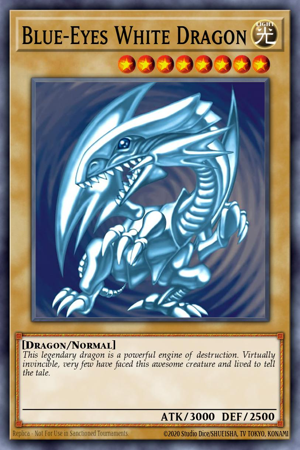

In [25]:
# display an image of the card
display_resized_image(df.iloc[0]['_id'])

<div style="page-break-after: always;"></div>

## 4.2 Most expensive cards based on set prices
As we saw previously, a card can have multiple versions with different prices. Card prices of rare limited cards can be quite high and play a major role in the trading card game community.
We can determine the most expensive cards by looking at the respective set prices of each card and sorting them in descending order.

In [55]:
# Define the aggregation pipeline
pipeline = [
    # Unwind the card_sets array to process each element separately
    {"$unwind": "$card_sets"},
    # Sort by set_price in descending order to ensure the highest price comes first
    {"$sort": {"card_sets.set_price": -1}},
    # Limit the results to 1 to get the top most expensive card set
    {"$limit": 10},
    # Project the results to format the output
    {"$project": {
        "_id": 0,
        "card_id": "$id",
        "name": "$name",
        "set_name": "$card_sets.set_name",
        "set_code": "$card_sets.set_code",
        "set_rarity": "$card_sets.set_rarity",
        "set_price": "$card_sets.set_price"
    }}
]

# Execute the aggregation query
result = cards.aggregate(pipeline)
df = pd.DataFrame(result)
df

,card_id,name,set_name,set_code,set_rarity,set_price
0,57728570,Crush Card Virus,Shonen Jump Championship 2007 Prize Card A,SJCS-EN004,Ultra Rare,115033.33
1,81059524,Des Volstgalph,Shonen Jump Championship 2005 Prize Card,SJC-EN002,Ultra Rare,95074.95
2,69015963,Cyber-Stein,Shonen Jump Championship 2004 Prize Card,SJC-EN001,Ultra Rare,24067.80
3,75500286,Gold Sarcophagus,Shonen Jump Championship 2007 Prize Card B,SJCS-EN005,Ultra Rare,24000.00
4,75500286,Gold Sarcophagus,Pharaoh Tour 2007 promotional cards,PT03-EN001,Ultra Rare,21127.30
5,85771019,Darklord Asmodeus,Yu-Gi-Oh! Championship Series 2010 Prize Cards,YCSW-EN001,Ultra Rare,20299.50
6,55713623,Shrink,Shonen Jump Championship 2006 Prize Card,SJC-EN003,Ultra Rare,18530.00
7,88643579,Dark End Dragon,Shonen Jump Championship 2009 Prize Card,SJCS-EN007,Ultra Rare,14693.33
8,54343893,Vice Dragon,Duel Disk - Yusei Version,DDY1-EN001,Ultra Rare,10001.09
9,63746411,Number 106: Giant Hand,Yu-Gi-Oh! Championship Series 2013 Prize Card,YCSW-EN006,Ultra Rare,8915.68


The most expensive card is the "Crush Card Virus" from the "Shonen Jump Championship 2007 Prize Card A" Set, with a price of 115'000 USD. Based on the set name, this card was only available by winning a competitive tournament, hence being one of the rarest cards and therefore the most expensive one based on the available prizes.
Interestingly, the "Gold Sarcophagus" card appears twice in the list of the top 10 most expensive cards, due to its different set versions being extremely rare.

<div style="page-break-after: always;"></div>

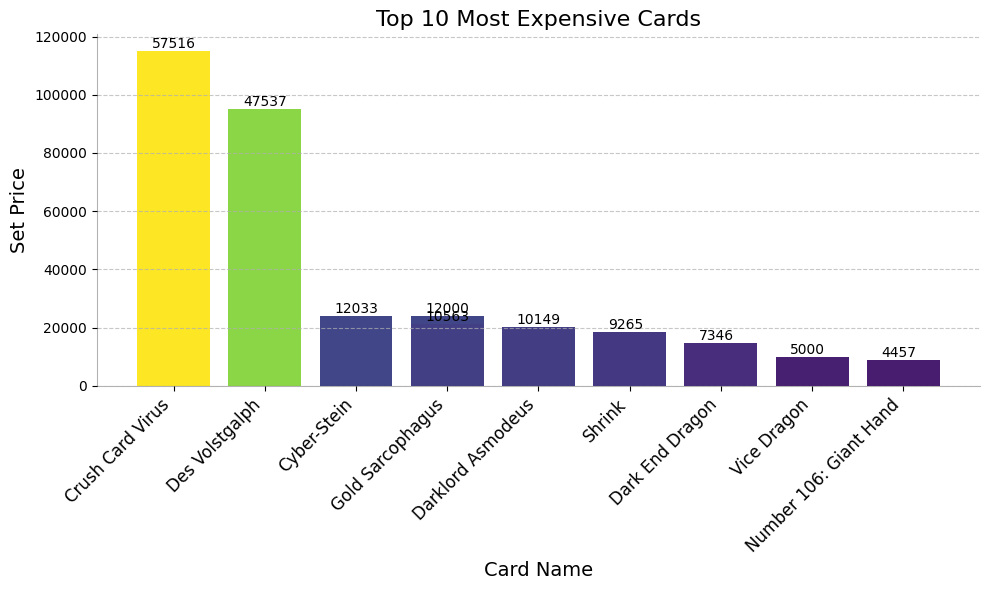

In [58]:
# make a nice plot
plt.figure(figsize=(10, 6))
bars = plt.bar(df['name'], df['set_price'], color=plt.cm.viridis(df['set_price'] / df['set_price'].max()))

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/5, yval, int(yval/2), va='bottom')  # Add the data value on top of each bar
    
# Set title and labels with increased font sizes
plt.title('Top 10 Most Expensive Cards', fontsize=16)
plt.xlabel('Card Name', fontsize=14)
plt.ylabel('Set Price', fontsize=14)

# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=45, ha='right', fontsize=12)

# Lighten borders and gridlines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_alpha(0.3)
plt.gca().spines['left'].set_alpha(0.3)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to make room for the rotated x-axis labels
plt.tight_layout()

# Show the plot
plt.show()

## 4.3 Sets containing the most expensive cards
Knowing which card sets contain the most expensive cards can be quite valuable, in case of a stored unopened pack of that specific set.
We can determine which set contains the most expensive cards by calculating the total price of all cards in each set and sorting the results in descending order.

In [19]:
# Define the aggregation pipeline
pipeline = [
    # Unwind the card_sets array to process each element separately
    {"$unwind": "$card_sets"},
    # Convert set_price from string to float (assuming all prices are valid floats)
    #{"$addFields": {"card_sets.set_price": {"$convert": {"input": "$card_sets.set_price", "to": "double", "onError": 0}}}},
    # Group by set_name to calculate the total price of all cards in the set
    {"$group": {
        "_id": "$card_sets.set_name",
        "total_price": {"$sum": "$card_sets.set_price"}
    }},
    # Sort by total_price in descending order to ensure the highest price comes first
    {"$sort": {"total_price": -1}},
    # Limit the results to 10 to get the top most expensive card sets
    {"$limit": 10},
    # Project the results to format the output
    {"$project": {
        "_id": 0,
        "set_name": "$_id",
        "total_price": 1
    }}
]

# Execute the aggregation query
result = list(cards.aggregate(pipeline))
df = pd.DataFrame(result)
df

,total_price,set_name
0,115033.33,Shonen Jump Championship 2007 Prize Card A
1,95074.95,Shonen Jump Championship 2005 Prize Card
2,30547.47,Yu-Gi-Oh! Championship Series 2010 Prize Cards
3,25119.51,Retro Pack
4,24067.80,Shonen Jump Championship 2004 Prize Card
5,24000.00,Shonen Jump Championship 2007 Prize Card B
6,21151.04,Pharaoh Tour 2007 promotional cards
7,18530.00,Shonen Jump Championship 2006 Prize Card
8,14693.33,Shonen Jump Championship 2009 Prize Card
9,13047.42,Yu-Gi-Oh! Championship Series 2011 Prize Card


A visual representation can help to compare the different prizes:

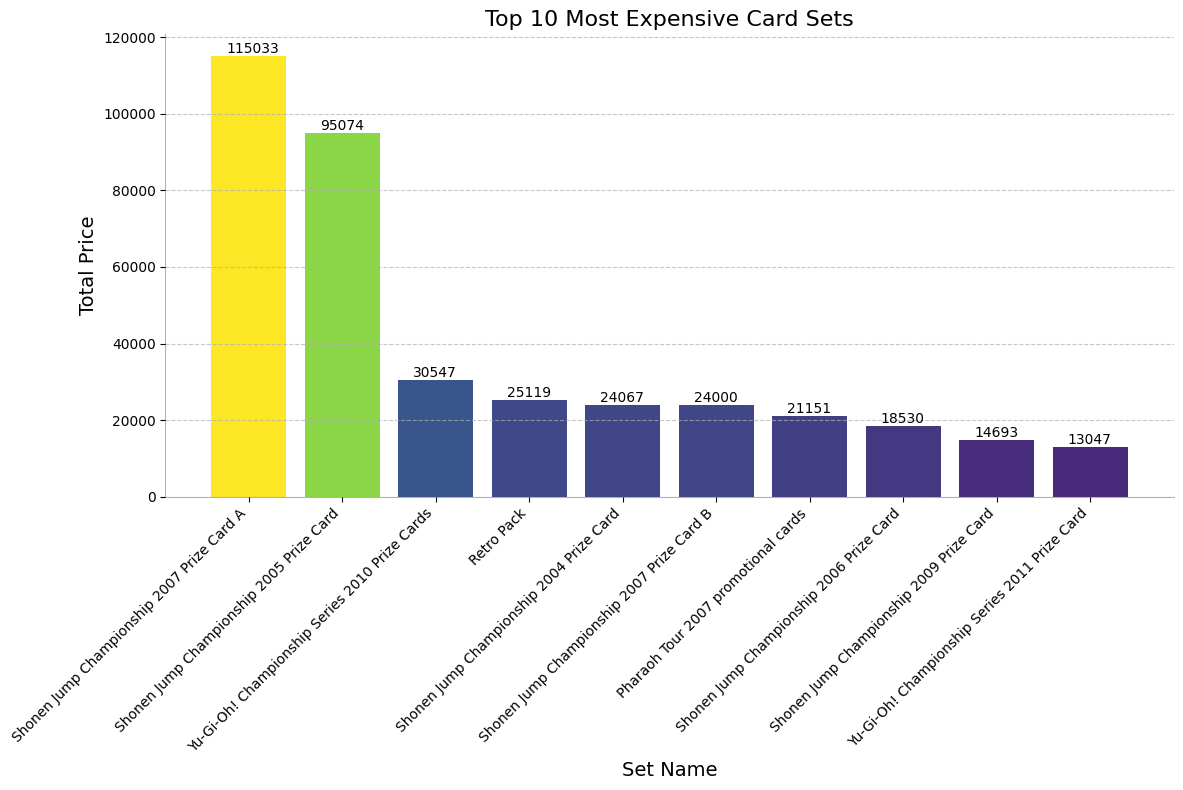

In [20]:
# Create the bar plot with enhancements
plt.figure(figsize=(12, 8))
bars = plt.bar(df['set_name'], df['total_price'], color=plt.cm.viridis(df['total_price'] / df['total_price'].max()))

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/5, yval, int(yval), va='bottom')  # Add the data value on top of each bar

# Set title and labels with increased font sizes
plt.title('Top 10 Most Expensive Card Sets', fontsize=16)
plt.xlabel('Set Name', fontsize=14)
plt.ylabel('Total Price', fontsize=14)

# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=45, ha='right', fontsize=10)

# Lighten borders and gridlines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_alpha(0.3)
plt.gca().spines['left'].set_alpha(0.3)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to make room for the rotated x-axis labels
plt.tight_layout()

# Show the plot
plt.show()

The set "Shonen Jump Championship 2007 Prize Card A" contains the most expensive cards, with a total price of 115,000 USD. This set is known for its rare and valuable cards, making it highly sought after by collectors and players alike. The "Gold Series 4: Pyramids Edition" set also features prominently in the list of top 10 most expensive card sets, indicating the high value of the cards in this set.

It is no surpise that the sets containing the most expensive cards can be pointed back to single expensive cards, therefore strongly overlapping with the previous analysis.

<div style="page-break-after: always;"></div>

## 4.4 Card Rarities per Set Over the Years

To analyze the distribution of rare cards over the years, we can group the cards by set name and set rarity to calculate the total number of rare cards in each set. By sorting the results by set name, we can observe how the number of rare cards has evolved over time.
Such analysis can provide insights into the trends in card rarities and the distribution of rare cards across different sets.

In [ ]:
pipeline = [
    # Unwind the card_sets array to process each element separately
    {"$unwind": "$card_sets"},
    
    # Lookup to join date information from the second collection
    {"$lookup": {
        "from": "card_sets", 
        "localField": "card_sets.set_name",
        "foreignField": "set_name",
        "as": "set_details"
    }},
    
    # Unwind the result of the lookup to process each joined document
    {"$unwind": "$set_details"},
    
    # Group by set_name and set_rarity to calculate the total number of rare cards in each set
    {"$group": {
        "_id": {"set_name": "$card_sets.set_name", "set_rarity": "$card_sets.set_rarity", "tcg_date": "$set_details.tcg_date"},
        "total_rare_cards": {"$sum": 1}
    }},
    
    # Sort by set_name in ascending order to ensure the results are ordered by set name
    {"$sort": {"_id.set_name": 1}},
    
    # Project the results to format the output, now including the tcg_date
    {"$project": {
        "_id": 0,
        "set_name": "$_id.set_name",
        "set_rarity": "$_id.set_rarity",
        "tcg_date": "$_id.tcg_date",
        "total_rare_cards": 1
    }},
    
    # Output the results into a new collection
    {"$out": "rarities_per_set"}
]

# Execute the aggregation query
cards.aggregate(pipeline)

In [59]:
# Get the collection for further analysis
rarities_per_set = db.rarities_per_set

Since there are a lot of different rarities, we can bin them into a few categories to make the analysis more readable. We will bin the rarities into "Common", "Rare", "Ultra Rare" and "Special Rarity". The "Special Rarity" category will include all rarities that do not fall into the other three categories.

In [60]:
pipeline = [
    # First, ensure tcg_date exists and is of a type that can represent a date
    {"$match": {
        "tcg_date": {"$exists": True, "$ne": ""}
    }},
    
    {"$addFields": {
        "year": {"$year": "$tcg_date"}
    }},
    
    # Exclude invalid years (e.g., NaN), the year 2024, and the year 2001
    {"$match": {
        "year": {"$nin": [2024, 2001], "$gte": 0}
    }},
    
    # Bin the rarities into specified categories
    {"$addFields": {
        "binned_rarity": {
            "$switch": {
                "branches": [
                    {"case": {"$eq": ["$set_rarity", "Common"]}, "then": "Common"},
                    {"case": {"$eq": ["$set_rarity", "Rare"]}, "then": "Rare"},
                    {"case": {"$eq": ["$set_rarity", "Ultra Rare"]}, "then": "Ultra Rare"},
                ],
                "default": "Special Rarity"
            }
        }
    }},
    
    # Group by year and binned_rarity
    {"$group": {
        "_id": {"year": "$year", "set_rarity": "$binned_rarity"},
        "total_cards": {"$sum": "$total_rare_cards"}
    }},
    
    # Sort the results by year and set_rarity
    {"$sort": {"_id.year": 1, "_id.set_rarity": 1}},
    
    # Optionally, you can project the results to format the output
    {"$project": {
        "_id": 0,
        "year": "$_id.year",
        "set_rarity": "$_id.set_rarity",
        "total_cards": 1
    }}
]

# Execute the aggregation query
result = rarities_per_set.aggregate(pipeline)
df = pd.DataFrame(result)

In [53]:
# Create a pivot table to reshape the data for plotting
df_pivot = df.pivot(index='year', columns='set_rarity', values='total_cards').fillna(0)

<Axes: title={'center': 'Distribution of Rare Cards Over the Years'}, xlabel='Year', ylabel='Total Cards'>

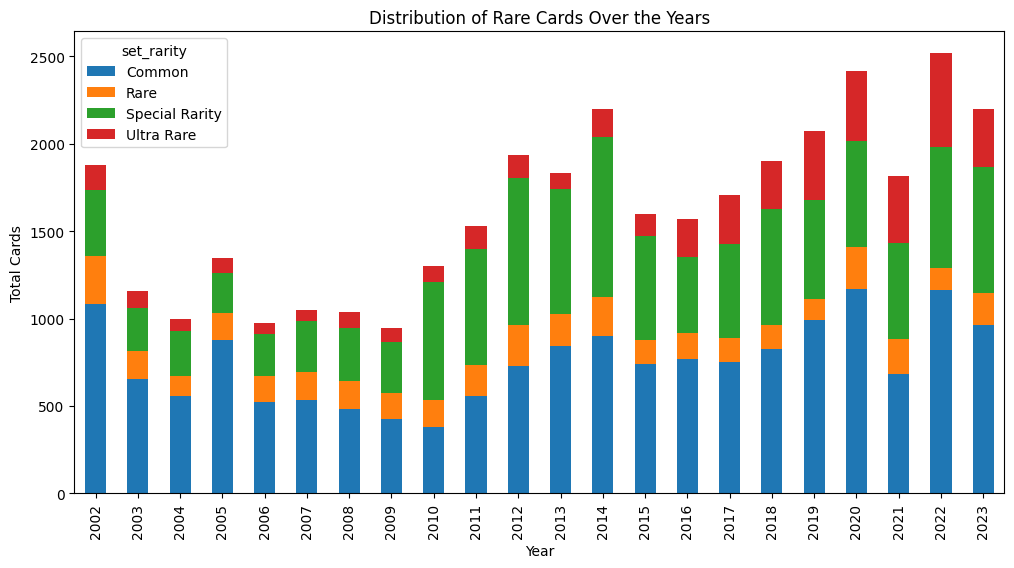

In [62]:
# Plot the data
df_pivot.plot(kind='bar', stacked=True, figsize=(12, 6), title='Distribution of Rare Cards Over the Years', ylabel='Total Cards', xlabel='Year')

The analysis of card rarities per set over the years reveals interesting trends in the distribution of rare cards. There are some interesting patterns visible in the distribution of rare cards across different sets and years, especially striking is the dip in the year 2021 which can most likely be attributed to the global pandemic.
Additionally, we can see a slight trend in the overall card releases over the years, that declined a bit after 2014. As well as the slight increase in ultra rare cards being released the last few years.

<div style="page-break-after: always;"></div>

## 4.5 Count Cards by Type

Looking at the distribution of card types can provide insights into the variety of cards available in the game. By grouping the cards by type and calculating the total number of cards of each type, we can determine the most common card types in the dataset.

In [34]:
# Define the aggregation pipeline
pipeline = [
    # Group by card type to calculate the total number of cards of each type
    {"$group": {
        "_id": "$type",
        "total_cards": {"$sum": 1}
    }},
    # Sort by total_cards in descending order to ensure the highest count comes first
    {"$sort": {"total_cards": -1}},
    # Project the results to format the output
    {"$project": {
        "_id": 0,
        "card_type": "$_id",
        "total_cards": 1
    }}
]

# Execute the aggregation query
result = list(cards.aggregate(pipeline))
df = pd.DataFrame(result)
df.head(10)

,total_cards,card_type
0,4648,Effect Monster
1,2539,Spell Card
2,1899,Trap Card
3,661,Normal Monster
4,507,XYZ Monster
5,457,Fusion Monster
6,453,Tuner Monster
7,419,Synchro Monster
8,401,Link Monster
9,267,Pendulum Effect Monster


<div style="page-break-after: always;"></div>

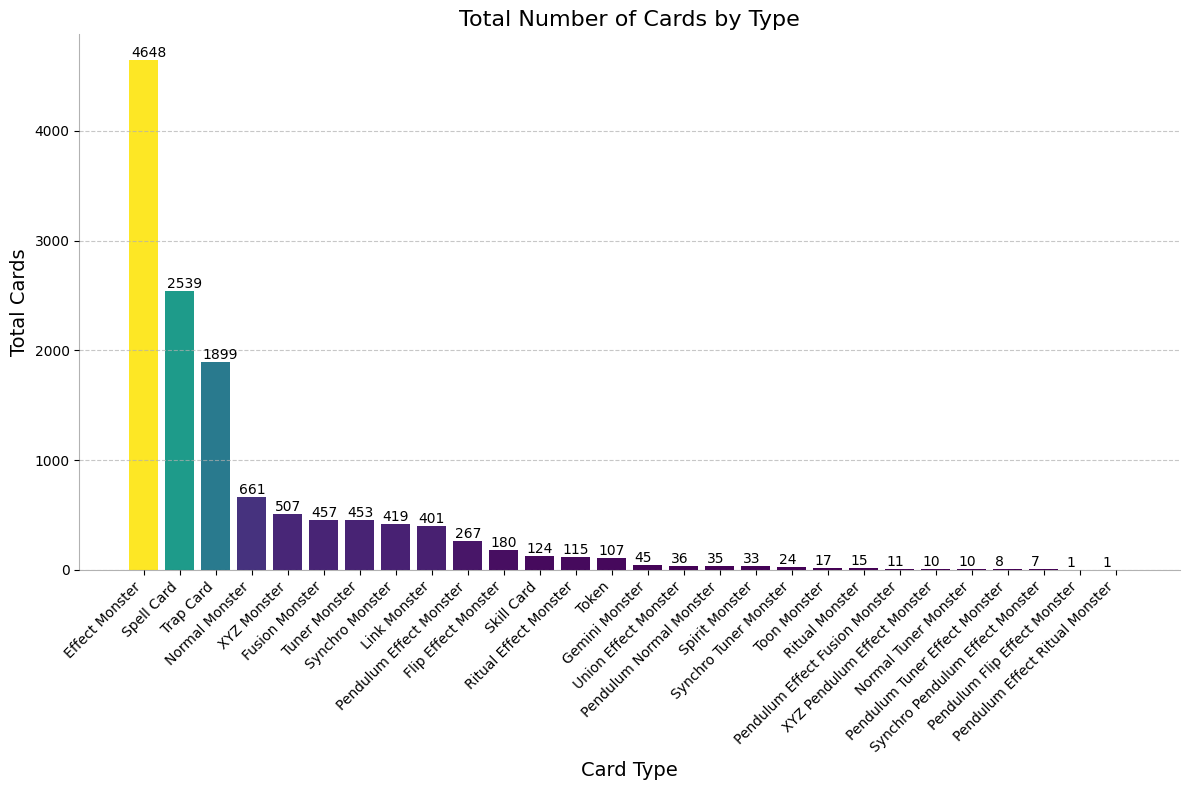

In [45]:
# make a nice plot
plt.figure(figsize=(12, 8))
bars = plt.bar(df['card_type'], df['total_cards'], color=plt.cm.viridis(df['total_cards'] / df['total_cards'].max()))

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/20, yval, int(yval), va='bottom')  # Add the data value on top of each bar
    
# Set title and labels with increased font sizes
plt.title('Total Number of Cards by Type', fontsize=16)
plt.xlabel('Card Type', fontsize=14)
plt.ylabel('Total Cards', fontsize=14)

# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=45, ha='right', fontsize=10)

# Lighten borders and gridlines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_alpha(0.3)
plt.gca().spines['left'].set_alpha(0.3)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to make room for the rotated x-axis labels
plt.tight_layout()

# Show the plot
plt.show()

It is quite evident that the most abundant card type is the "Effect Monster", followed by "Normal Monster" and "Spell Card". This is not surprising, as effect monsters are a core component of the game and play a crucial role in gameplay strategies..

<div style="page-break-after: always;"></div>

## 4.6 Card Popularity

To determine the most popular cards of the week, we can look at the number of times a card has been viewed in the database this week (does not include API/external views)

In [21]:
# Define the aggregation pipeline
pipeline = [
    { "$unwind": "$misc_info" },
    { "$sort": { "misc_info.viewsweek": -1 } },
    { "$limit": 100 },
    { "$project": { "name": 1, "type": 1, "viewsweek": "$misc_info.viewsweek" } }
]

result = cards.aggregate(pipeline)
df = pd.DataFrame(result)
df.head(10)

,_id,name,type,viewsweek
0,660592ebef8a28605d7533d7,Ash Blossom & Joyous Spring,Tuner Monster,26338
1,660592ebef8a28605d75479e,Infinite Impermanence,Trap Card,19062
2,660592ebef8a28605d754f8f,"Nibiru, the Primal Being",Effect Monster,11518
3,660592ebef8a28605d753e8f,Effect Veiler,Tuner Monster,11232
4,660592ebef8a28605d755f64,Triple Tactics Talent,Spell Card,10764
5,660592ebef8a28605d753726,Called by the Grave,Spell Card,9412
6,660592ebef8a28605d753e07,Droll & Lock Bird,Effect Monster,9361
7,660592ebef8a28605d7556ae,S:P Little Knight,Link Monster,8112
8,660592ebef8a28605d755316,Pot of Prosperity,Spell Card,7852
9,660592ebef8a28605d755b84,Super Starslayer TY-PHON - Sky Crisis,XYZ Monster,6944


<div style="page-break-after: always;"></div>

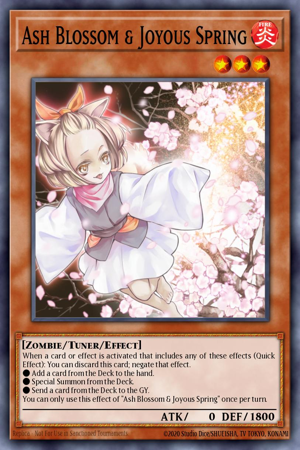

In [22]:
# have a look at the most viewed card this week
display_resized_image(df.iloc[0]['name'])

<div style="page-break-after: always;"></div>

We can also create a sentiment analysis looking at the upvotes and downvotes of the cards:

In [48]:
pipeline = [
    {"$unwind": "$misc_info"},
    {"$project": {
        "name": 1,
        "type": 1,
        "sentimentScore": {"$subtract": ["$misc_info.upvotes", "$misc_info.downvotes"]}
    }},
    {"$sort": {"sentimentScore": -1}}
]

result = cards.aggregate(pipeline)
df = pd.DataFrame(result)
df.head(10)

,_id,name,type,sentimentScore
0,660592ebef8a28605d75355c,Black Luster Soldier,Ritual Monster,2597
1,660592ebef8a28605d753d85,Dragon Master Knight,Fusion Monster,1524
2,660592ebef8a28605d75355d,Black Luster Soldier - Envoy of the Beginning,Effect Monster,1491
3,660592ebef8a28605d753b17,Dark Magician,Normal Monster,1476
4,660592ebef8a28605d753562,Black Luster Soldier - Super Soldier,Ritual Effect Monster,1264
5,660592ebef8a28605d75355e,Black Luster Soldier - Envoy of the Evening Tw...,Effect Monster,1122
6,660592ebef8a28605d755912,Slifer the Sky Dragon,Effect Monster,618
7,660592ebef8a28605d755498,Raigeki,Spell Card,548
8,660592ebef8a28605d7537b4,Chaos Emperor Dragon - Envoy of the End,Effect Monster,354
9,660592ebef8a28605d755923,Smile World,Spell Card,343


Looking at the cards with the most positive sentiments, one can quickly recognize that these are some of the all time favorite cards, such as "Dark Magician" and "Black Luster Soldier".

<div style="page-break-after: always;"></div>

# 5 Conclusions

Since its creation, the Yu-Gi-Oh! TCG has not only provided a battleground for strategic duels but also fostered a substantial trading market. This market is propelled by the rarity and desirability of certain cards. Our analysis shows the enduring legacy of iconic cards such as the 'Blue-Eyes White Dragon' and the 'Dark Magician.' These cards have seen numerous reprints and remain at the heart of the game's lore and player interest. The TCG's secondary market is highly volatile, especially for rare cards exclusive to tournaments. Konami's strategic efforts to maintain player engagement and market vitality are reflected in the evolving distribution of card rarities over the years.

# 6 Learnings

Our analysis involved the ELT process, where MongoDB played a pivotal role. MongoDB's flexible schema and powerful aggregation framework allowed us to efficiently manage and analyze the diverse dataset comprising card information, images, and market prices. MongoDB's document-oriented nature made it easy to handle complex nested structures, such as card sets and rarity distributions. This allowed us to gain insights quickly and accurately. Additionally, MongoDB's scalability was crucial in accommodating the extensive dataset, ensuring that our analysis could evolve alongside the ever-expanding universe of the Yu-Gi-Oh! TCG.

This project highlighted the importance of selecting the right tools and technologies for data analysis. The multifaceted dataset was navigated with ease thanks to MongoDB's robust features and flexibility. This analysis provided insights into the dynamics of the Yu-Gi-Oh! TCG and demonstrated the powerful synergy between analytical methodologies and modern database systems.